In [ ]:
# Load the data and libraries
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from scipy.special import expit as invlogit

data = pd.read_csv('./data/Free throw.csv.zip').drop('Timestamp', axis=1)
data.columns = ['age', 'gender', 'athleticism', 'y0', 'y1']

true_effect = data.y1 - data.y0
y0 = data.y0
y1 = data.y1
x = data.athleticism
n = len(data)

# Create fake data
np.random.seed(42)
n = 1000
x = np.random.randint(1, 11, size=n)
y1 = np.random.binomial(50, invlogit(0.2 * x - 1.5))
y0 = np.random.binomial(50, invlogit(0.2 * x - 2.0))
data = pd.DataFrame({"x": x, "y1": y1, "y0": y0})

true_effect = data.y1 - data.y0

print(f'True ATE for all respondents {true_effect.mean():.2f} with an sd of {true_effect.std():.2f}')


True ATE for all respondents 5.19 with an sd of 4.58


In [2]:
### Assign random treatment

z = np.random.binomial(1, 0.5, size=n)
y = np.where(z == 1, y1, y0)

est = np.mean(y[z == 1]) - np.mean(y[z == 0])
s1 = np.std(y[z == 1], ddof=1)
s0 = np.std(y[z == 0], ddof=1)
n1 = np.sum(z == 1)
n0 = np.sum(z == 0)
se = np.sqrt(s1**2 / n1 + s0**2 / n0)

print(f'Random treatment ATE {est:.2f} with SE of {se:.2f}')

Random treatment ATE 5.34 with SE of 0.45


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'beta'}>

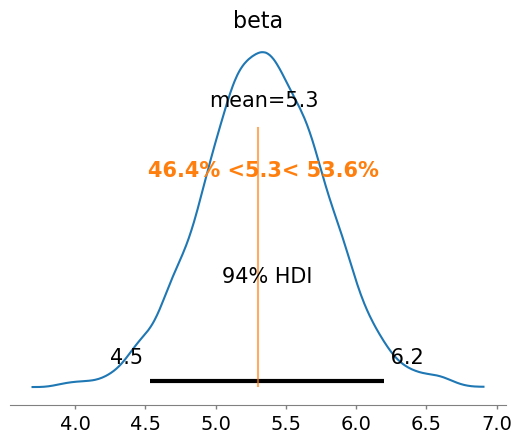

In [5]:
## Next let's estimate it using a model

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    #sigma = pm.HalfCauchy("sigma", beta=5)
    # Changed sigma prior to HalfNormal that has thinner tail and therefore shrinks signma towards zero
    sigma = pm.HalfNormal("sigma", sigma=5)  

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)
pm.plot_posterior(trace, var_names=["beta"], ref_val=5.3)

(array([  10.,   40.,  194.,  559., 1056., 1115.,  713.,  236.,   58.,
          19.]),
 array([3.69474515, 4.01609954, 4.33745394, 4.65880833, 4.98016272,
        5.30151712, 5.62287151, 5.94422591, 6.2655803 , 6.5869347 ,
        6.90828909]),
 <BarContainer object of 10 artists>)

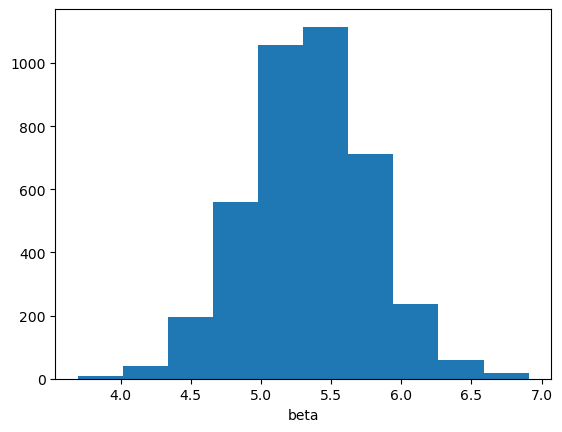

In [6]:
trace.posterior.beta.plot.hist()

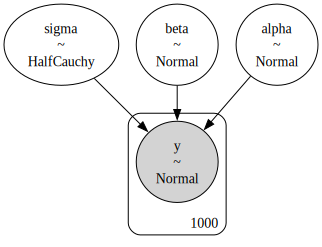

In [38]:
pm.model_to_graphviz(model)

In [12]:
### Add dias

p_treat = invlogit(x - 5.5)
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimating the ATE with the same model gives biased estimate:

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,10.612,0.229,10.181,11.045,0.005,0.004,2143.0,2326.0,1.0
beta,14.645,0.325,14.028,15.266,0.007,0.005,2099.0,2543.0,1.0
sigma,5.158,0.116,4.941,5.376,0.002,0.002,3007.0,2834.0,1.0


In [13]:
# In order to correct the bias we stratify with treatment

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_z = pm.Normal("beta_z", mu=0, sigma=10)
    beta_x = pm.Normal("beta_x", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta_z * z + beta_x * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, beta_x, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.903,0.234,3.459,4.340,0.006,0.004,1745.0,1864.0,1.0
beta_x,2.036,0.055,1.933,2.137,0.001,0.001,1518.0,1513.0,1.0
beta_z,5.810,0.322,5.182,6.395,0.007,0.005,1889.0,1841.0,1.0
sigma,3.331,0.075,3.187,3.468,0.001,0.001,2853.0,2537.0,1.0


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_x'}>,
       <Axes: title={'center': 'beta_z'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

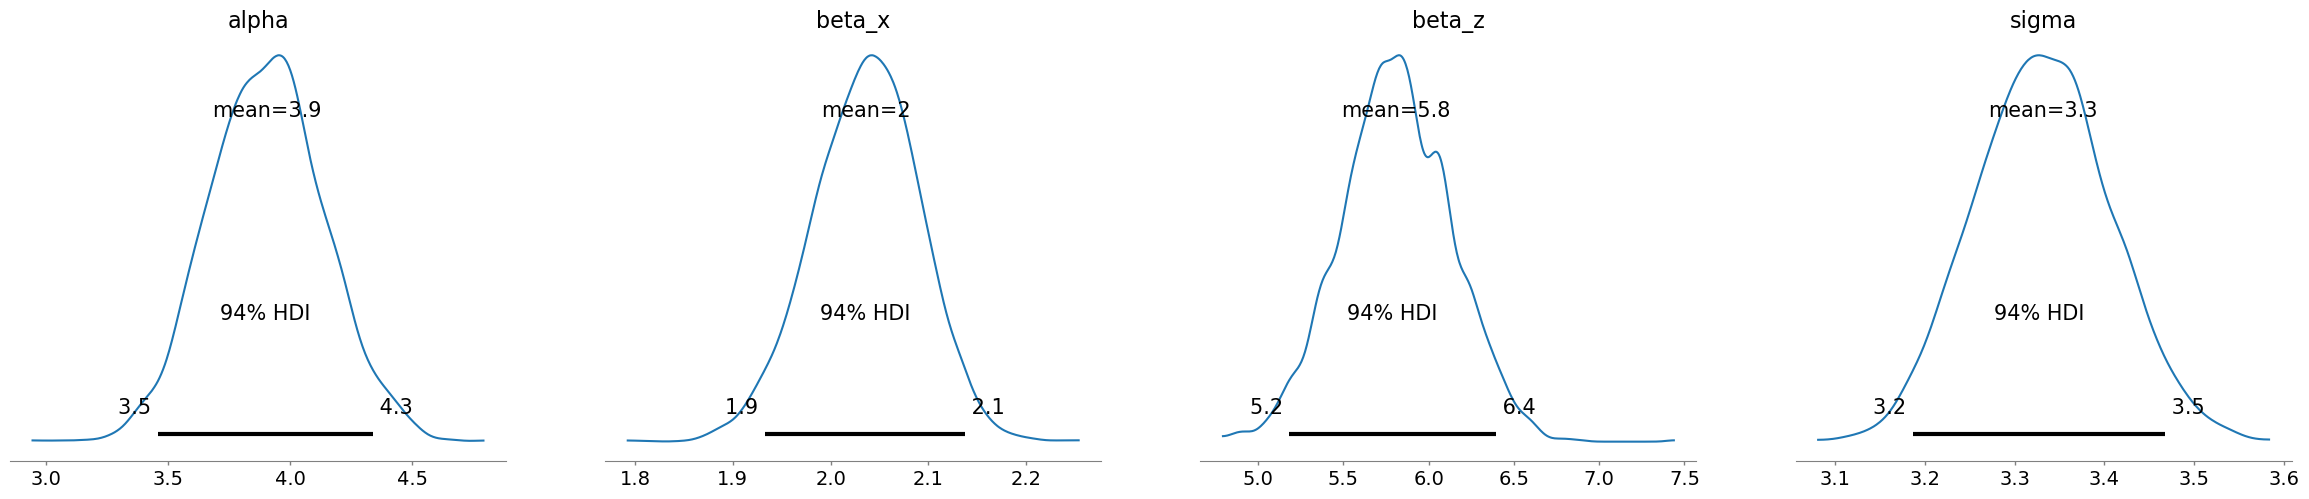

In [14]:
pm.plot_posterior(trace)

In [57]:
# Biased in the other direction

p_treat = invlogit(-(x - 5.5))
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimate the ATE with a model

with pm.Model() as model3:
    ...

### Our own dataset

OK, we have established that with the fake data our model behaves as expected. Let's next try again with the 17 observations that we gathered in the class, but now we set the seed for np.random that will keep treatment assignments fixed between different runs.

In [38]:
np.random.seed(42)

data = pd.read_csv('./data/Free throw.csv.zip').drop('Timestamp', axis=1)
data.columns = ['age', 'gender', 'athleticism', 'y0', 'y1']

print(data.head())

true_effect = data.y1 - data.y0
y0 = data.y0
y1 = data.y1
x = data.athleticism
n = len(data)

print(f'True ATE for all respondents {true_effect.mean():.2f} with an sd of {true_effect.std():.2f}')

   age  gender  athleticism  y0  y1
0   24    Male            2  10  25
1   21    Male            7   3  15
2   28    Male            8  15  25
3   39    Male            7  10  40
4   31  Female            6  15  20
True ATE for all respondents 12.82 with an sd of 7.26


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'beta'}>

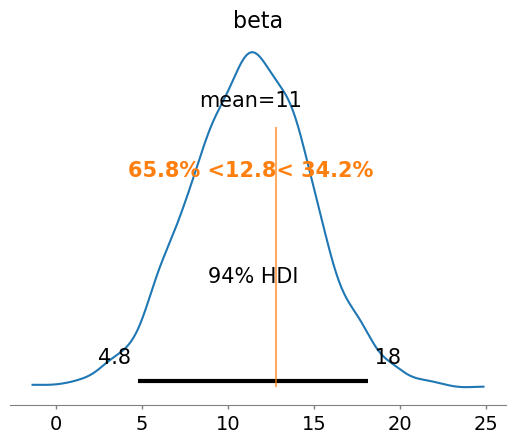

In [39]:
# Assign random treatment
z = np.random.binomial(1, 0.5, size=n)
y = np.where(z == 1, y1, y0)

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)
    # Changed sigma prior to HalfNormal that has thinner tail and therefore shrinks signma towards zero
    #sigma = pm.HalfNormal("sigma", sigma=5)  

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)
pm.plot_posterior(trace, var_names=["beta"], ref_val=12.8)

In [43]:
# Next we add bias and run the same model that should give us much more optimistic estimate of the ETA

np.random.seed(42)

p_treat = invlogit(x - 5.5)
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimating the ATE with the same model gives biased estimate:

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.647,2.446,3.134,12.390,0.059,0.046,1699.0,1847.0,1.0
beta,19.125,3.327,12.833,25.474,0.083,0.060,1604.0,2027.0,1.0
sigma,7.068,1.212,4.991,9.316,0.025,0.021,2320.0,2277.0,1.0


In [44]:
# Now let's debiase our data - which should return beta_z closter to the true value

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_z = pm.Normal("beta_z", mu=0, sigma=10)
    beta_x = pm.Normal("beta_x", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta_z * z + beta_x * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, beta_x, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.566,4.907,-8.762,10.110,0.119,0.101,1696.0,1865.0,1.0
beta_x,1.672,0.995,-0.294,3.519,0.025,0.022,1635.0,1484.0,1.0
beta_z,15.324,3.831,8.245,22.247,0.082,0.067,2181.0,2128.0,1.0
sigma,6.926,1.241,4.907,9.452,0.030,0.025,1677.0,1664.0,1.0


### Yay, it worked! :)